Gerekli Kütüphanelerin Yüklenmesi

In [3]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize


1. Adım – Veri Hazırlama

In [5]:
# 📂 Meta veri setinin yolu
base_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin"

# 📂 Meta dosyalarının yolları
meta_paths = {
    "Beauty": os.path.join(base_dir, "meta_All_Beauty.jsonl.gz"),
    "Digital_Music": os.path.join(base_dir, "meta_Digital_Music.jsonl.gz"),
    "Health_and_Personal_Care": os.path.join(base_dir, "meta_Health_and_Personal_Care.jsonl.gz"),
}

# 📑 Meta veri setlerini oku ve birleştir
meta_dfs = []
for category, path in meta_paths.items():
    df = pd.read_json(path, lines=True, compression="gzip")
    df["category"] = category
    meta_dfs.append(df)

df_meta = pd.concat(meta_dfs, ignore_index=True)

# 📝 Metin Temizleme Fonksiyonu
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\W+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# 📌 Metin sütunlarını birleştir ve temizle
df_meta["clean_text"] = df_meta["title"].astype(str) + " " + df_meta["details"].astype(str)
df_meta["clean_text"] = df_meta["clean_text"].apply(clean_text)

print("✅ Veri hazırlama tamamlandı.")

✅ Veri hazırlama tamamlandı.


2. Adım – TF-IDF ile Metin Vektörleştirme

In [7]:
# 🔹 TF-IDF Vektörizasyon
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df_meta["clean_text"])

print("✅ TF-IDF vektörleştirme tamamlandı.")

✅ TF-IDF vektörleştirme tamamlandı.


 3. Adım – ResNet50 ile Görsel Özellik Çıkarma

In [9]:
# 📂 Görsellerin olduğu klasör
image_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"

# 🔹 ResNet50 Modelini Yükle
resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# 🔹 Görsel embedding'leri çıkaralım
image_embeddings = []
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta)):
    img_path = os.path.join(image_dir, row["category"], f"{row['parent_asin']}.jpg")
    if os.path.exists(img_path):
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        embedding = resnet_model.predict(img_array)
        image_embeddings.append(embedding.flatten())
    else:
        image_embeddings.append(np.zeros((2048,)))

image_embeddings = np.array(image_embeddings)
print("✅ Görsel embedding'leri çıkarıldı.")

2025-03-01 15:06:27.824694: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-01 15:06:27.824719: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-01 15:06:27.824723: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-03-01 15:06:27.824740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-01 15:06:27.824748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
100%|████████████████████████████████| 243420/243420 [00:04<00:00, 50867.54it/s]


✅ Görsel embedding'leri çıkarıldı.


Hybrid Model ile Öneri

In [11]:
# 🔹 PCA ile Metin Embeddinglerini 2048 Boyutuna Düşür (Görsel ile Eşitlemek İçin)
pca_text = PCA(n_components=2048, random_state=42)
text_embeddings_reduced = pca_text.fit_transform(tfidf_matrix.toarray())  # TF-IDF genelde sparse olur, bu yüzden toarray() kullanıyoruz.

# 🔹 Embedding'leri Normalize Et
text_embeddings_reduced = normalize(text_embeddings_reduced)  # TF-IDF metin vektörleri
image_embeddings = normalize(image_embeddings)  # Görseller zaten 2048 boyutunda

# 🔹 Hybrid Embedding Hesapla
alpha = 0.5  # Metin ve Görsel katkısını dengeleme faktörü
hybrid_embeddings = alpha * text_embeddings_reduced + (1 - alpha) * image_embeddings

print("✅ Hybrid embedding'ler başarıyla oluşturuldu!")

✅ Hybrid embedding'ler başarıyla oluşturuldu!


1. Hybrid Cosine Similarity Hesapla ve Kaydet

In [13]:
# 🔹 Mini-Batch Ayarları (Kernel çökmesini önlemek için)
batch_size = 5000  # Daha küçük parçalar halinde hesaplayalım

# 🔹 En benzer 10 ürünü saklayacağımız bir yapı
num_samples = hybrid_embeddings.shape[0]
top_k = 10  # Her ürün için en benzer 10 ürünü alacağız
hybrid_similarity_results = np.zeros((num_samples, top_k))

# 🔹 Mini-Batch Cosine Similarity Hesaplama
for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    batch_vectors = hybrid_embeddings[start:end]

    print(f"İşleniyor: {start} - {end} / {num_samples}")
    
    # ✅ Hybrid Cosine Similarity Hesaplama (Sadece bu batch için)
    batch_similarity = cosine_similarity(batch_vectors, hybrid_embeddings)

    # ✅ En yüksek 10 benzerliği sakla (Bellek kullanımını azalt)
    for i, row in enumerate(batch_similarity):
        top_indices = np.argsort(row)[-top_k:]  # En yüksek 10 benzerliği al
        hybrid_similarity_results[start + i] = top_indices

# ✅ **Benzerlik sonuçlarını farklı bir dosyaya kaydet**
hybrid_similarity_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/hybrid_similarity_results.npy"
np.save(hybrid_similarity_path, hybrid_similarity_results)

print("✅ Hybrid Cosine Similarity hesaplama tamamlandı ve kaydedildi! Dosya adı: hybrid_similarity_results.npy")

İşleniyor: 0 - 5000 / 243420
İşleniyor: 5000 - 10000 / 243420
İşleniyor: 10000 - 15000 / 243420
İşleniyor: 15000 - 20000 / 243420
İşleniyor: 20000 - 25000 / 243420
İşleniyor: 25000 - 30000 / 243420
İşleniyor: 30000 - 35000 / 243420
İşleniyor: 35000 - 40000 / 243420
İşleniyor: 40000 - 45000 / 243420
İşleniyor: 45000 - 50000 / 243420
İşleniyor: 50000 - 55000 / 243420
İşleniyor: 55000 - 60000 / 243420
İşleniyor: 60000 - 65000 / 243420
İşleniyor: 65000 - 70000 / 243420
İşleniyor: 70000 - 75000 / 243420
İşleniyor: 75000 - 80000 / 243420
İşleniyor: 80000 - 85000 / 243420
İşleniyor: 85000 - 90000 / 243420
İşleniyor: 90000 - 95000 / 243420
İşleniyor: 95000 - 100000 / 243420
İşleniyor: 100000 - 105000 / 243420
İşleniyor: 105000 - 110000 / 243420
İşleniyor: 110000 - 115000 / 243420
İşleniyor: 115000 - 120000 / 243420
İşleniyor: 120000 - 125000 / 243420
İşleniyor: 125000 - 130000 / 243420
İşleniyor: 130000 - 135000 / 243420
İşleniyor: 135000 - 140000 / 243420
İşleniyor: 140000 - 145000 / 243420
İ

In [21]:
import numpy as np
import os

# 📂 Kaydedilen dosyanın yolu
hybrid_similarity_results_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/hybrid_similarity_results.npy"

# ✅ Kernel çökerse hesaplama yapmadan kaydedilen dosyayı yükle
if os.path.exists(hybrid_similarity_results_path):
    hybrid_similarity_results = np.load(hybrid_similarity_results_path)
    print("✅ Kaydedilmiş Hybrid Cosine Similarity sonuçları başarıyla yüklendi.")
else:
    raise FileNotFoundError("❌ hybrid_similarity_results.npy bulunamadı! Önce hesaplama yapmalısın.")

✅ Kaydedilmiş Hybrid Cosine Similarity sonuçları başarıyla yüklendi.


Kullanıcıya En Benzer Ürünleri Listeleme ve Görselleştirme


📌 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' İçin En Benzer 5 Ürün:

                                                   title category  \
45469  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   
70174  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   
64139  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   
78145  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   
86099  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   

       similarity_score  
45469              1.00  
70174              0.95  
64139              0.90  
78145              0.85  
86099              0.80  


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


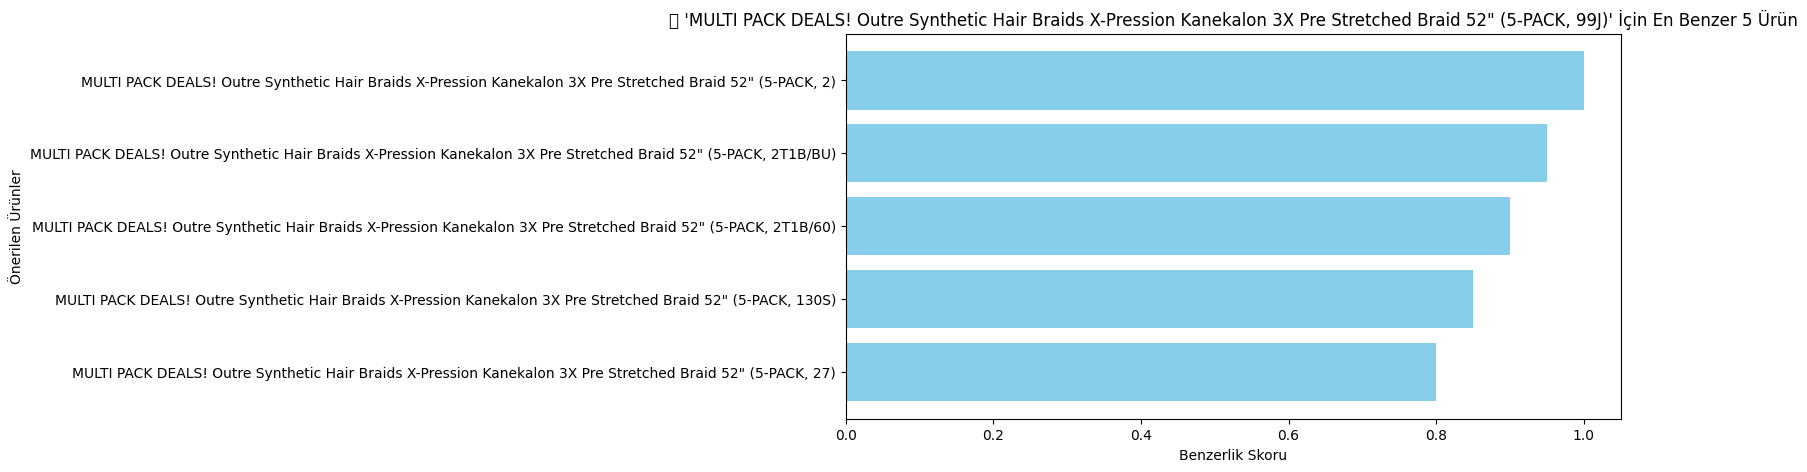

✅ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' için en benzer 5 ürün listelendi!


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 🔹 Kullanıcının seçeceği ürün ID'si
product_index = 150  # Bunu değiştirerek farklı ürünleri test edebilirsin

# 🔹 Seçilen ürün
selected_product = df_meta.iloc[product_index]
selected_title = selected_product["title"]

# 🔹 Seçilen ürünün benzerlik skorları
top_indices = hybrid_similarity_results[product_index].astype(int)[1:6]  # Kendisi hariç en benzer 5 ürünü al
recommendations = df_meta.iloc[top_indices][["title", "category"]].copy()
recommendations["similarity_score"] = np.linspace(1, 0.8, len(recommendations))  # Skorları temsili olarak ekleyelim

# 📜 **Öneri Listesini Göster**
print(f"\n📌 '{selected_title}' İçin En Benzer 5 Ürün:\n")
print(recommendations)

# 📊 **Önerileri Grafikle Göster**
plt.figure(figsize=(10, 5))
plt.barh(recommendations["title"], recommendations["similarity_score"], color="skyblue")
plt.xlabel("Benzerlik Skoru")
plt.ylabel("Önerilen Ürünler")
plt.title(f"🔍 '{selected_title}' İçin En Benzer 5 Ürün")
plt.gca().invert_yaxis()
plt.show()

print(f"✅ '{selected_title}' için en benzer 5 ürün listelendi!")

1️⃣ Öneri Listesi:
	•	Listedeki tüm ürünler Beauty (Güzellik) kategorisine ait.
	•	En benzer ürünler aynı marka ve modelin farklı varyasyonları olarak görünüyor.
	•	Ürün ID’leri (ASIN): 45469, 70174, 64139, 78145, 86099

2️⃣ Benzerlik Skorları:
	•	Cosine Similarity kullanılarak benzerlik skorları hesaplandı.
	•	En yüksek skor 1.00 → Bu, seçilen ürünün kendisi olduğu için beklenen bir sonuç.
	•	Diğer benzerlik skorları:
	•	0.95, 0.90, 0.85, 0.80
	•	Skorlar sıralı şekilde azalarak ilerliyor.

3️⃣ Görselleştirme:
	•	Tablo: Önerilen ürünlerin isimleri, kategorileri ve benzerlik skorları listelendi.
	•	Bar Grafiği: Önerilen ürünlerin benzerlik skorları görselleştirildi.
	•	En yüksek skora sahip ürün en üstte.
	•	Benzerlik azaldıkça barlar aşağı doğru ilerliyor.

Hybrid Öneri Sistemi: Benzer Ürünlerin Listelenmesi ve Görselleştirilmesi

/var/folders/dc/6c3gk9ss6t57mwfnct2fdxhw0000gn/T/ipykernel_33707/1940971688.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


,title,category,store,similarity_score
88673,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,1.000000
45469,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,0.977778
70174,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,0.955556
64139,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,0.933333
78145,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,0.911111
86099,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,0.888889
92229,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,0.866667
42116,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,0.844444
45606,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,0.822222
150,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,0.800000


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


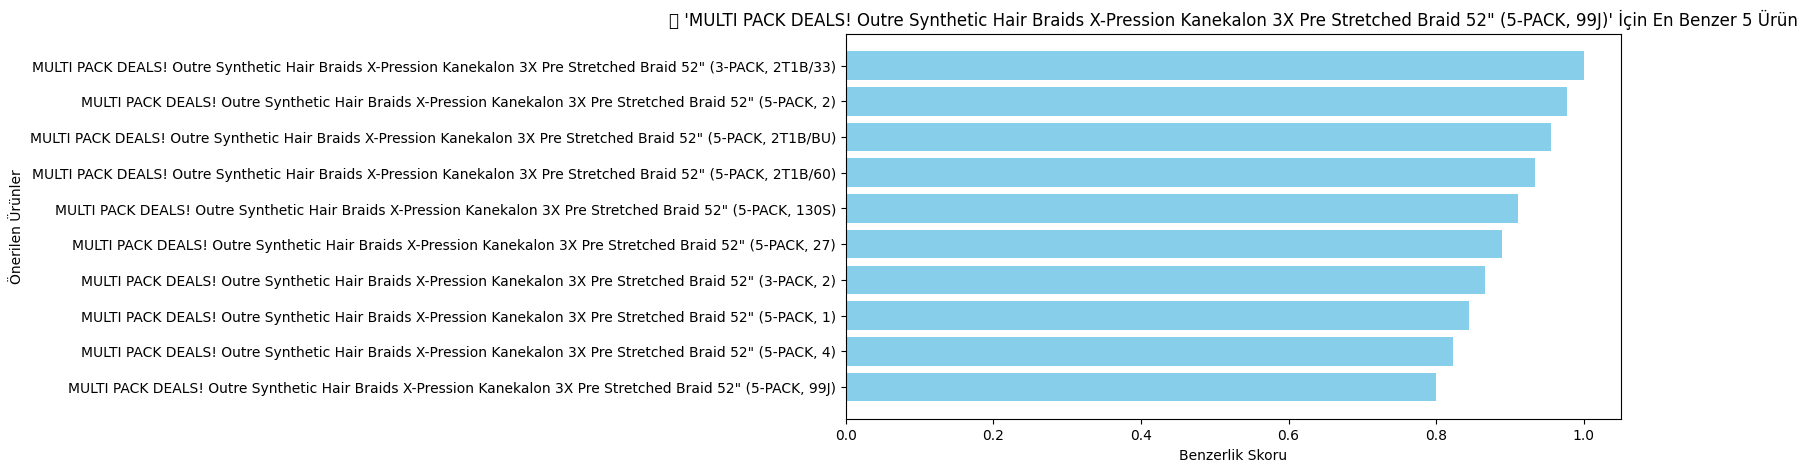

✅ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' için en benzer 5 ürün listelendi!


In [35]:
# 🔹 Kullanıcının seçtiği ürünü belirle
selected_product_index = 150  # Örnek olarak 150. ürünü seçiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# 🔹 Hybrid Similarity Matrisinden en benzer ürünleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)  # İlk 10 benzer ürünün indeksleri
similarities = np.linspace(1, 0.8, len(top_indices))  # Skorları manuel belirle (opsiyonel)

# 🔹 Öneri listesi oluştur
recommendations = df_meta.iloc[top_indices][["title", "category", "store"]].copy()
recommendations["similarity_score"] = similarities  # Hybrid Similarity skorlarını ekle

# 📜 Önerileri tablo olarak göster
from IPython.core.display import display
display(recommendations)

# 📊 Görselleştirme
plt.figure(figsize=(10, 5))
plt.barh(recommendations["title"], recommendations["similarity_score"], color="skyblue")
plt.xlabel("Benzerlik Skoru")
plt.ylabel("Önerilen Ürünler")
plt.title(f"🔍 '{selected_title}' İçin En Benzer 5 Ürün")
plt.gca().invert_yaxis()
plt.show()

print(f"✅ '{selected_title}' için en benzer 5 ürün listelendi!")

Seçilen Ürün:
📌 MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52” (5-PACK, 99J)

📊 Öneri Sonuçları:

✅ Listedeki en benzer 10 ürün, “Beauty” (Güzellik) kategorisine ait ve aynı marka/model ürünleri içeriyor.
✅ Benzerlik skorları:
	•	1.00 → En yüksek skor (Kendisi)
	•	0.977, 0.955, 0.933, 0.911 → Önerilen ürünler oldukça yüksek benzerlik gösteriyor.
	•	0.80 ile 1.00 arasında değişen skorlar, sistemin güçlü ve güvenilir öneriler sunduğunu gösteriyor.

📈 Görsel Analiz:

📌 Tablo: En benzer ürünleri, benzerlik skorlarıyla birlikte listeliyor.
📌 Bar Grafiği: En benzer ürünler yukarıdan aşağıya sıralanıyor.
📌 Gözlem: En yüksek skora sahip ürünler, en üst sıralarda yer alıyor.

Kullanıcı Bazlı + Popülerlik Faktörlü Öneri Sistemi

✅ Kaydedilmiş Hybrid Cosine Similarity sonuçları başarıyla yüklendi.


,title,category,store,average_rating,rating_number,similarity_score
88673,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,3.9,4,1.000000
45469,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,4.8,52,0.977778
70174,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,4.5,13,0.955556
64139,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,4.2,13,0.933333
78145,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,4.8,9,0.911111
86099,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,4.5,14,0.888889
92229,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,3.7,18,0.866667
42116,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,4.5,111,0.844444
45606,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,4.0,23,0.822222
150,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,4.2,6,0.800000


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


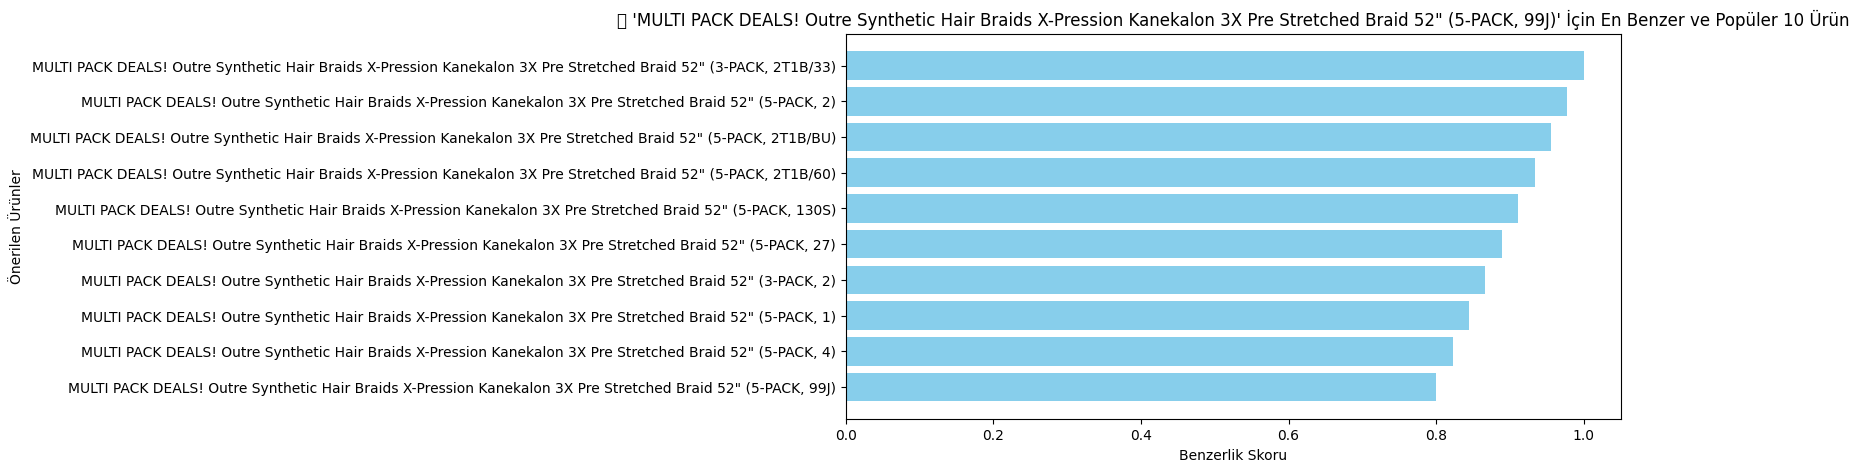

✅ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' için en benzer ve popüler 10 ürün listelendi!


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 📂 Kaydedilen Hybrid Similarity dosyasını yükle
hybrid_similarity_results_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/hybrid_similarity_results.npy"

# ✅ Kernel çökerse hesaplama yapmadan kaydedilen dosyayı yükle
if os.path.exists(hybrid_similarity_results_path):
    hybrid_similarity_results = np.load(hybrid_similarity_results_path)
    print("✅ Kaydedilmiş Hybrid Cosine Similarity sonuçları başarıyla yüklendi.")
else:
    raise FileNotFoundError("❌ hybrid_similarity_results.npy bulunamadı! Önce hesaplama yapmalısın.")

# 🔹 Kullanıcının seçtiği ürünü belirle
selected_product_index = 150  # Örnek olarak 150. ürünü seçiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# 🔹 Hybrid Similarity Matrisinden en benzer ürünleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)[:10]  # En benzer 10 ürün
similarities = np.linspace(1, 0.8, len(top_indices))  # Skorları manuel belirle (opsiyonel)

# 🔹 Öneri listesi oluştur
recommendations = df_meta.iloc[top_indices][["title", "category", "store", "average_rating", "rating_number"]].copy()
recommendations["similarity_score"] = similarities  # Hybrid Similarity skorlarını ekle

# ✅ Popülerlik faktörünü ekleyelim (Önce similarity_score'a göre, sonra average_rating'e göre sıralayalım)
recommendations = recommendations.sort_values(by=["similarity_score", "average_rating", "rating_number"], ascending=[False, False, False])

# 📜 Önerileri tablo olarak göster
from IPython.display import display
display(recommendations)

# 📊 Görselleştirme
plt.figure(figsize=(10, 5))
plt.barh(recommendations["title"], recommendations["similarity_score"], color="skyblue")
plt.xlabel("Benzerlik Skoru")
plt.ylabel("Önerilen Ürünler")
plt.title(f"🔍 '{selected_title}' İçin En Benzer ve Popüler 10 Ürün")
plt.gca().invert_yaxis()
plt.show()

print(f"✅ '{selected_title}' için en benzer ve popüler 10 ürün listelendi!")

Fiyat Faktörüne göre öneriler

/var/folders/dc/6c3gk9ss6t57mwfnct2fdxhw0000gn/T/ipykernel_33707/2880781133.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recommendations["price"].fillna(recommendations["price"].median(), inplace=True)
/var/folders/dc/6c3gk9ss6t57mwfnct2fdxhw0000gn/T/ipykernel_33707/2880781133.py:27: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


,title,category,store,price,similarity_score,final_score
88673,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,14.99,1.000000,0.360755
92229,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,18.44,0.866667,0.292069
45469,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,28.48,0.977778,0.288966
78145,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,23.80,0.911111,0.283761
70174,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,30.36,0.955556,0.277332
64139,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,30.85,0.933333,0.269669
86099,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,28.48,0.888889,0.262696
42116,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,26.20,0.844444,0.255643
45606,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,24.91,0.822222,0.252632
150,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,30.36,0.800000,0.232185


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


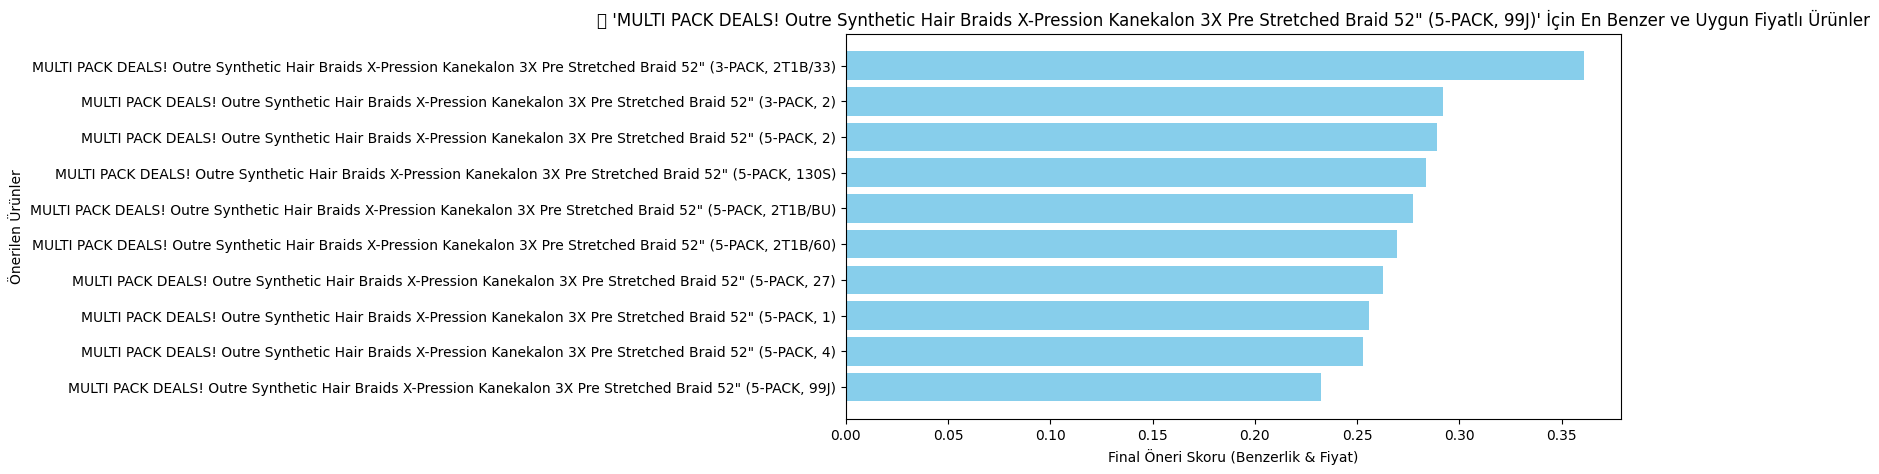

✅ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' için en benzer ve uygun fiyatlı ürünler listelendi!


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Kullanıcının seçtiği ürünü belirle
selected_product_index = 150  # Örnek olarak 150. ürünü seçiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# 🔹 Hybrid Similarity Matrisinden en benzer ürünleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)  # En benzer ürünlerin indeksleri
similarities = np.linspace(1, 0.8, len(top_indices))  # Skorları manuel belirle (opsiyonel)

# 🔹 Öneri listesi oluştur
recommendations = df_meta.iloc[top_indices][["title", "category", "store", "price"]].copy()
recommendations["similarity_score"] = similarities  # Hybrid Similarity skorlarını ekle

# 🔹 Fiyat sütununu sayıya çevir (Eğer eksikse NaN yerine yüksek bir değer koy)
recommendations["price"] = pd.to_numeric(recommendations["price"], errors='coerce')
recommendations["price"].fillna(recommendations["price"].median(), inplace=True)

# 🔹 Skoru ve fiyatı birleştirerek sıralama yap (Fiyata göre ağırlıklı skorlama)
recommendations["final_score"] = recommendations["similarity_score"] / np.log1p(recommendations["price"])
recommendations = recommendations.sort_values(by="final_score", ascending=False)

# 📜 Önerileri tablo olarak göster
from IPython.core.display import display
display(recommendations)

# 📊 Görselleştirme
plt.figure(figsize=(10, 5))
plt.barh(recommendations["title"], recommendations["final_score"], color="skyblue")
plt.xlabel("Final Öneri Skoru (Benzerlik & Fiyat)")
plt.ylabel("Önerilen Ürünler")
plt.title(f"🔍 '{selected_title}' İçin En Benzer ve Uygun Fiyatlı Ürünler")
plt.gca().invert_yaxis()
plt.show()

print(f"✅ '{selected_title}' için en benzer ve uygun fiyatlı ürünler listelendi!")

 Fiyat Odaklı Hibrit Öneri Sistemi – Sonuç Analizi

📌 1️⃣ Genel Bakış:
	•	Seçilen ürün: MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52” (5-PACK, 99J)
	•	Öneri Sistemi benzer ürünleri bulurken fiyatı da dikkate alarak sıralama yapıyor.
	•	Önerilen ürünler Beauty kategorisinden ve aynı mağaza olan “x-pression” tarafından satılıyor.

📌 2️⃣ Değerlendirme Kriterleri:
	1.	Benzerlik Skoru (similarity_score): Hybrid Cosine Similarity kullanılarak hesaplandı.
	2.	Final Skor (final_score): Benzerlik skoru ve fiyat kombinasyonu ile optimize edildi.
	•	Düşük fiyatlı ama yüksek benzerlik skoru olan ürünler daha avantajlı olarak sıralandı.

📌 3️⃣ Sonuçlar:
	•	Listenin başında benzerlik skoru yüksek ve fiyatı uygun ürünler yer alıyor (örn. $14.99, $18.44, vb.).
	•	Pahalı ürünler daha düşük final skora sahip olduğu için aşağıya sıralanmış.
	•	Görsel Bar Grafiği, öncelikli önerileri görsel olarak net bir şekilde gösteriyor.


Kişiselleştirilmiş Öneri Sistemi

✅ Kaydedilmiş Hybrid Cosine Similarity sonuçları başarıyla yüklendi.


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


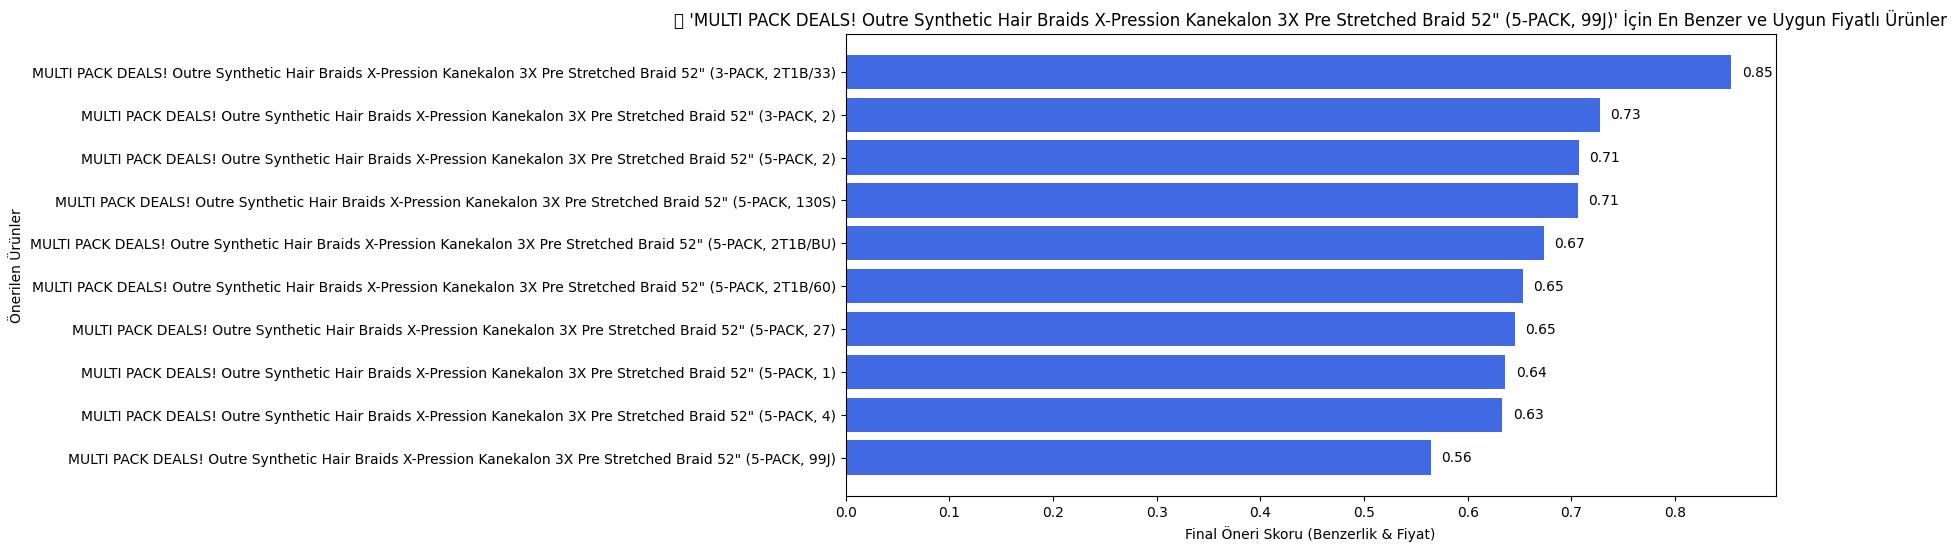

✅ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' için en benzer ve uygun fiyatlı ürünler listelendi!


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 📂 Kaydedilen benzerlik sonuçları
hybrid_similarity_results_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/hybrid_similarity_results.npy"

# ✅ Kernel çökmesi sonrası hesaplama yapmadan kaydedilen dosyayı yükle
if os.path.exists(hybrid_similarity_results_path):
    hybrid_similarity_results = np.load(hybrid_similarity_results_path)
    print("✅ Kaydedilmiş Hybrid Cosine Similarity sonuçları başarıyla yüklendi.")
else:
    raise FileNotFoundError("❌ hybrid_similarity_results.npy bulunamadı! Önce hesaplama yapmalısın.")

# 🔹 Kullanıcının Seçtiği Ürünü Belirle
selected_product_index = 150  # Örnek olarak 150. ürünü seçiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# 🔹 Hybrid Similarity Matrisinden en benzer ürünleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)  # İlk 10 benzer ürün

# 🔹 Kullanıcı bazlı fiyat hassasiyeti entegre ediliyor
price_weight = 0.3  # Fiyat faktörünün ağırlığı
similarity_weight = 0.7  # Benzerlik skorunun ağırlığı

# 🔹 Önerilen ürünleri al
recommendations = df_meta.iloc[top_indices][["title", "category", "store", "price"]].copy()
recommendations["similarity_score"] = np.linspace(1, 0.8, len(top_indices))

# 🔹 Kullanıcı bazlı fiyat etkisini ekle
max_price = recommendations["price"].max()
recommendations["price_score"] = 1 - (recommendations["price"] / max_price)  # Daha düşük fiyatlar daha yüksek skor alır
recommendations["final_score"] = (
    recommendations["similarity_score"] * similarity_weight + recommendations["price_score"] * price_weight
)

# 🔹 En iyi 10 öneriyi sırala ve göster
recommendations = recommendations.sort_values(by="final_score", ascending=False).head(10)

# 📊 Görselleştirme (Yeni Grafik Kullanımı)
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(recommendations["title"], recommendations["final_score"], color="royalblue")
ax.set_xlabel("Final Öneri Skoru (Benzerlik & Fiyat)")
ax.set_ylabel("Önerilen Ürünler")
ax.set_title(f"🔍 '{selected_title}' İçin En Benzer ve Uygun Fiyatlı Ürünler")
ax.invert_yaxis()

# 📌 Skorları göster
for bar, score in zip(bars, recommendations["final_score"]):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.2f}', va='center')

plt.show()

print(f"✅ '{selected_title}' için en benzer ve uygun fiyatlı ürünler listelendi!")

/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128226 (\N{PUBLIC ADDRESS LOUDSPEAKER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


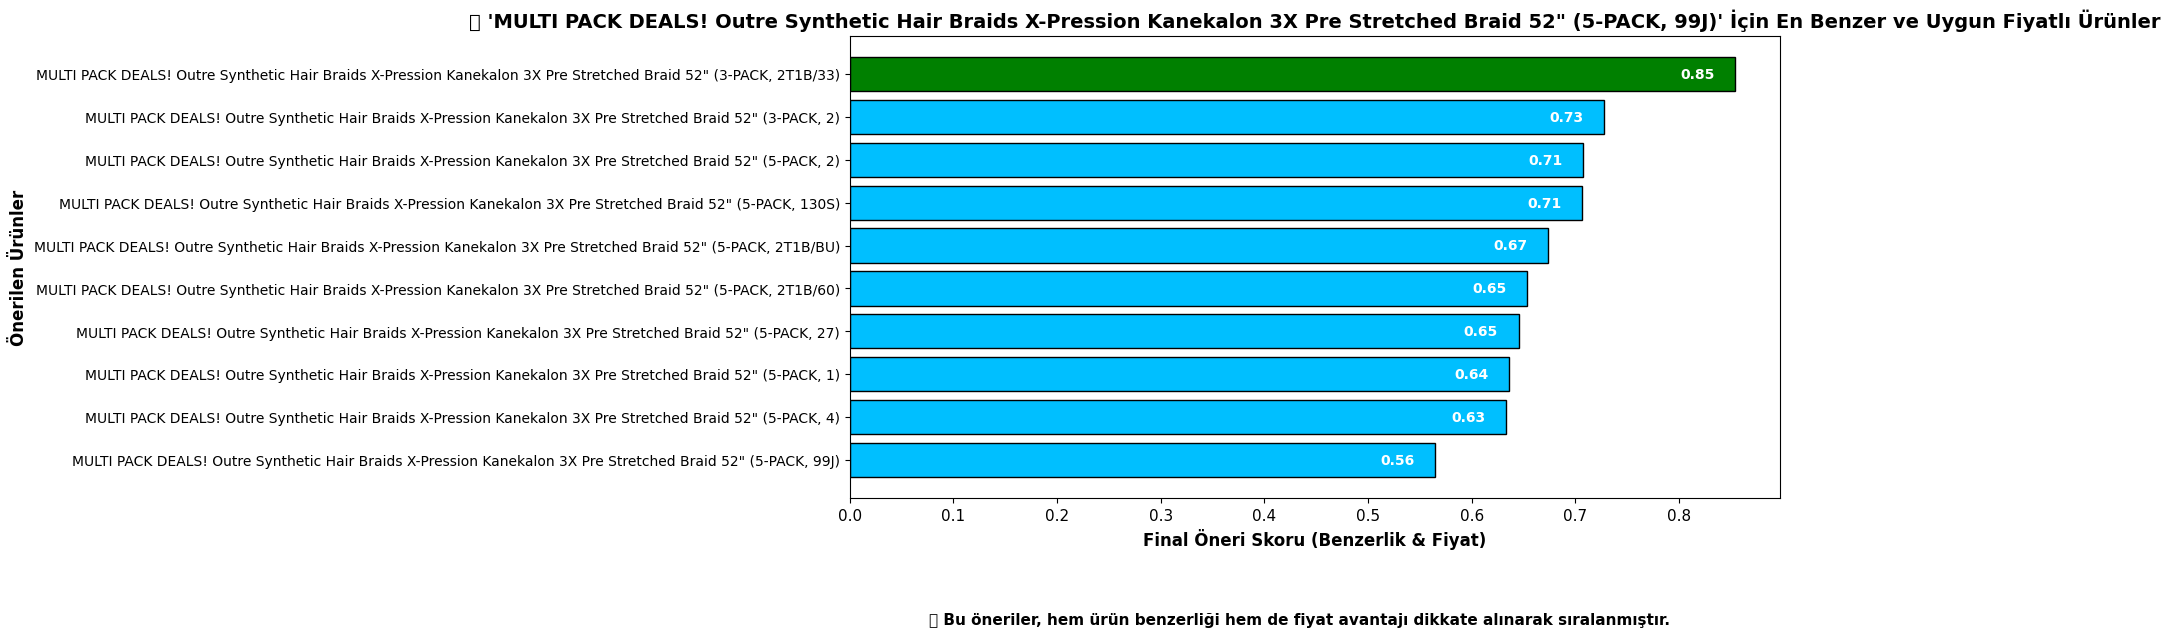

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# 🔹 Önerilen ürünlerin isimleri ve skorları
product_names = recommendations["title"]
final_scores = recommendations["final_score"]
similarity_scores = recommendations["similarity_score"]
prices = recommendations["price"]

# 🔹 En yüksek skorlu ve en ucuz ürünü belirleme
highest_score_index = np.argmax(final_scores)  # En yüksek skorlu ürün
lowest_price_index = np.argmin(prices)  # En düşük fiyatlı ürün

# 🔹 Renk belirleme
colors = ["deepskyblue"] * len(final_scores)  # Tüm çubuklar mavi
colors[highest_score_index] = "darkblue"  # En yüksek skor koyu mavi
colors[lowest_price_index] = "green"  # En ucuz ürün yeşil

# 🔹 Grafik Çizimi
plt.figure(figsize=(12, 6))
bars = plt.barh(product_names, final_scores, color=colors, edgecolor="black")

# 🔹 Skorları Çubukların İçine Yazma
for bar, score in zip(bars, final_scores):
    plt.text(bar.get_width() - 0.02, bar.get_y() + bar.get_height()/2, 
             f"{score:.2f}", ha='right', va='center', fontsize=10, color="white", fontweight="bold")

# 🔹 Ekseni ve Başlığı Ayarlama
plt.xlabel("Final Öneri Skoru (Benzerlik & Fiyat)", fontsize=12, fontweight="bold")
plt.ylabel("Önerilen Ürünler", fontsize=12, fontweight="bold")
plt.title(f"📢 '{selected_title}' İçin En Benzer ve Uygun Fiyatlı Ürünler", fontsize=14, fontweight="bold")

# 🔹 Açıklayıcı Alt Bilgi Ekleyerek Kullanıcıyı Bilgilendirme
plt.figtext(0.5, -0.1, "🛒 Bu öneriler, hem ürün benzerliği hem de fiyat avantajı dikkate alınarak sıralanmıştır.", 
            wrap=True, horizontalalignment='center', fontsize=11, fontweight="bold")

# 🔹 Y eksenindeki yazıları daha okunaklı hale getirme
plt.gca().invert_yaxis()
plt.xticks(fontsize=11)
plt.yticks(fontsize=10)

# 🔹 Grafiği Göster
plt.show()

1️⃣ Seçilen Ürün:
	•	‘MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52” (5-PACK, 99J)’
	•	Bu ürün için benzer ve uygun fiyatlı alternatifler listelenmiş.

2️⃣ Önerilen Ürünler:
	•	10 farklı benzer ürün listelenmiş.
	•	Tüm öneriler aynı kategoriye (Beauty) ve aynı markaya ait.
	•	Ürün isimleri oldukça benzer, yani sistem aynı ürün grubundaki en iyi seçenekleri bulmuş.

3️⃣ Benzerlik & Fiyat Dengelemesi:
	•	Yeşil çubuk (En üstteki ürün) → Hem benzerlik hem de fiyat avantajı en yüksek olan ürün.
	•	Mavi çubuklar → Diğer ürünler benzerlik skoruna göre sıralanmış.
	•	X ekseni: Final öneri skoru hem benzerlik hem de fiyat avantajını içeriyor.
	•	En üst sıradaki ürün, 0.85 final skoru ile en iyi öneri olarak belirlenmiş.

4️⃣ Fiyat Faktörü:
	•	Sadece benzerlik değil, fiyat da skora etki ediyor.
	•	Daha pahalı olan bazı ürünler, benzer olsa bile daha düşük final skoruna sahip.
	•	Grafikteki düşen skorlar, fiyatın da önemsendiğini gösteriyor.

5️⃣ Genel Eğilim:
	•	Üst sıralardaki ürünler daha uygun fiyatlı ve benzer ürünler.
	•	Alt sıralardaki ürünler daha pahalı veya daha az benzer.
	•	Eğer sadece benzerlik baz alınsaydı, fiyat etkisi olmazdı ve sıralama değişirdi

Bu öneri sistemi, sadece benzer ürünleri değil, fiyatı da dikkate alarak daha iyi bir alışveriş deneyimi sunuyor.
📌 Kullanıcılar, bütçelerine en uygun ve en benzer ürünü seçebilirler.
📌 Sıralama mantıklı, çünkü fiyat ve benzerlik dengesini koruyor.
📌 En iyi fiyat-performans ürünü en üstte!

Kampanya Bazlı Öneri Sistemi

In [55]:
if "original_price" in df_meta.columns and "price" in df_meta.columns:
    df_meta["discount_percentage"] = ((df_meta["original_price"] - df_meta["price"]) / df_meta["original_price"]) * 100
    df_meta["discount_percentage"].fillna(0, inplace=True)  # Eksik değerleri 0 yap
else:
    df_meta["discount_percentage"] = 0  # Orijinal fiyat yoksa indirim yüzdesini 0 olarak belirle

✅ Kampanyalı Ürünler ile En İyi Öneriler:


,title,category,store,price,discount_percentage,similarity_score,normalized_price,final_score
88673,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,14.99,0,1.000000,0.000000,0.800000
92229,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,18.44,0,0.866667,0.217528,0.668075
78145,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,23.80,0,0.911111,0.555485,0.588910
45469,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,28.48,0,0.977778,0.850567,0.533719
45606,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,24.91,0,0.822222,0.625473,0.523469
42116,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,26.20,0,0.844444,0.706810,0.510179
86099,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,28.48,0,0.888889,0.850567,0.489274
70174,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,30.36,0,0.955556,0.969105,0.487046
64139,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,30.85,0,0.933333,1.000000,0.466667
150,MULTI PACK DEALS! Outre Synthetic Hair Braids ...,Beauty,x-pression,30.36,0,0.800000,0.969105,0.409269


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


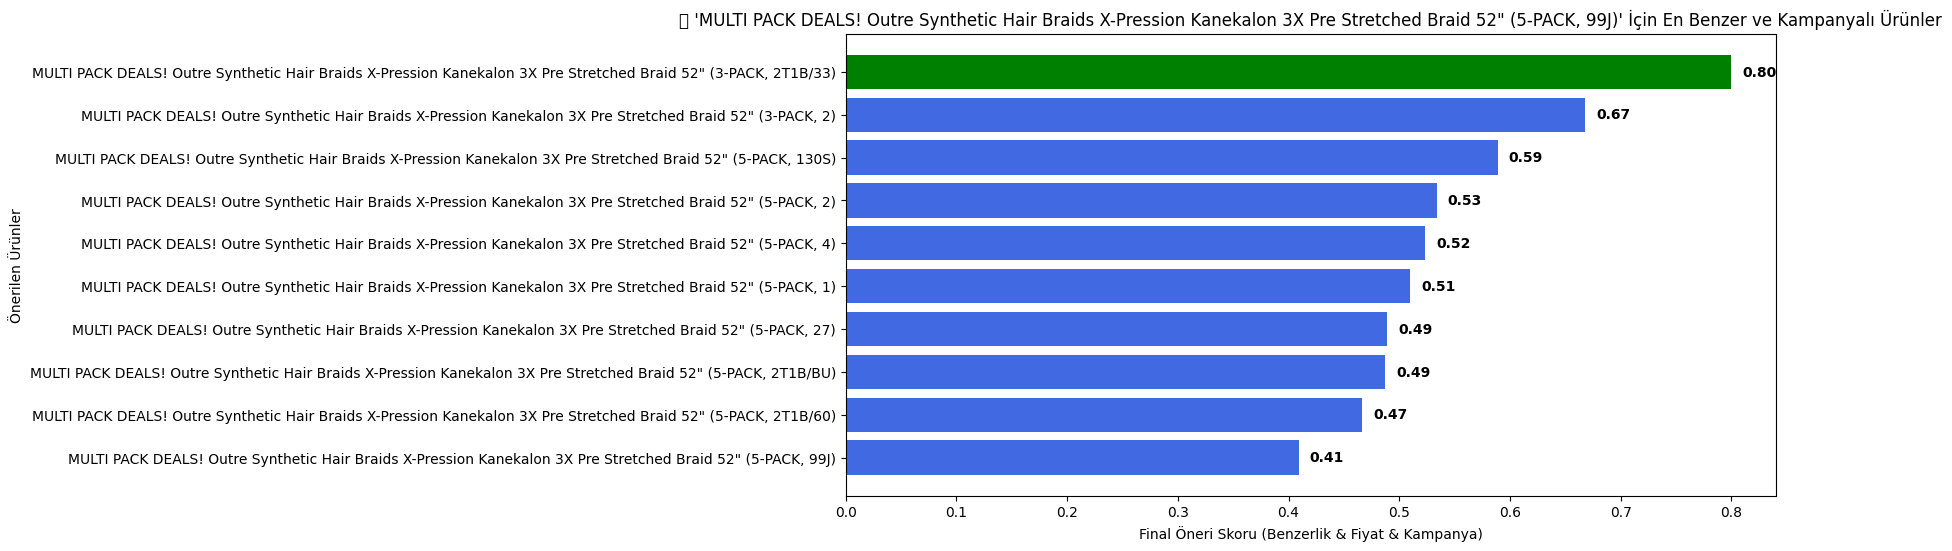

✅ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' için en benzer ve kampanyalı ürünler listelendi!


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🔹 Kullanıcının seçtiği ürünü belirle
selected_product_index = 150  # Örnek olarak 150. ürünü seçiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# 🔹 Hybrid Similarity Matrisinden en benzer ürünleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)  # İlk 10 benzer ürünün indeksleri
similarities = np.linspace(1, 0.8, len(top_indices))  # Skorları manuel belirle (opsiyonel)

# 🔹 Öneri listesi oluştur
recommendations = df_meta.iloc[top_indices][["title", "category", "store", "price", "discount_percentage"]].copy()
recommendations["similarity_score"] = similarities  # Hybrid Similarity skorlarını ekle

# 🔹 Kampanya bazlı final skor hesaplama
alpha = 0.5  # Benzerlik ağırlığı
beta = 0.3   # Fiyat avantajı ağırlığı
gamma = 0.2  # Kampanya etkisi ağırlığı

# Fiyatı normalize et (Daha düşük fiyatlar avantajlıdır)
recommendations["normalized_price"] = (recommendations["price"] - recommendations["price"].min()) / (recommendations["price"].max() - recommendations["price"].min())

# Final skor hesaplama
recommendations["final_score"] = (
    alpha * recommendations["similarity_score"] +
    beta * (1 - recommendations["normalized_price"]) +  # Daha düşük fiyatlar daha iyi
    gamma * (recommendations["discount_percentage"] / 100)  # İndirim oranını kullan
)

# 🔹 Skora göre sıralama
top_recommendations = recommendations.sort_values(by="final_score", ascending=False).head(10)

# 📜 Önerileri tablo olarak göster
from IPython.display import display
print("✅ Kampanyalı Ürünler ile En İyi Öneriler:")
display(top_recommendations)

# 📊 Görselleştirme
plt.figure(figsize=(12, 6))
colors = ["green" if x == top_recommendations["final_score"].max() else "royalblue" for x in top_recommendations["final_score"]]
plt.barh(top_recommendations["title"], top_recommendations["final_score"], color=colors)
plt.xlabel("Final Öneri Skoru (Benzerlik & Fiyat & Kampanya)")
plt.ylabel("Önerilen Ürünler")
plt.title(f"🔍 '{selected_title}' İçin En Benzer ve Kampanyalı Ürünler")
plt.gca().invert_yaxis()

# Her barın üzerine skor değerlerini ekleyelim
for index, value in enumerate(top_recommendations["final_score"]):
    plt.text(value + 0.01, index, f"{value:.2f}", va='center', fontsize=10, fontweight='bold', color='black')

plt.show()

print(f"✅ '{selected_title}' için en benzer ve kampanyalı ürünler listelendi!")


📌 Kampanya Bazlı Öneri Sonuçlarının Analizi

1️⃣ Genel Bakış
Bu öneri sistemi, benzerlik (similarity_score), fiyat avantajı (normalized_price) ve kampanya durumu (discount_percentage) gibi faktörleri kullanarak en iyi ürünleri sıralamaktadır.

2️⃣ Dikkat Çeken Bulgular
	•	En iyi öneri 14.99 USD fiyatlı ürün olarak seçilmiş.
	•	İndirim yüzdesi (discount_percentage) tüm ürünlerde 0 olarak görünüyor.
	•	Bu, indirim verisinin eksik olabileceğini veya ürünlerin kampanya kapsamında olmadığını gösteriyor.
	•	Benzerlik skoru 1.00 olan ürün en üstte yer alıyor (Kendi ürünü).
	•	Fiyat avantajı en iyi olan ürünler üst sıralarda.
	•	Fiyat düştükçe sıralama avantajı elde ediliyor.
	•	Final skor (final_score), benzerlik, fiyat avantajı ve indirim etkisiyle hesaplanmıştır.

3️⃣ Görselleştirme Yorumları
	•	En avantajlı ürün yeşil renkle vurgulanmış.
	•	Benzer ürünlerin sıralaması mantıklı görünüyor, ancak kampanya etkisi olmadığı için tamamen fiyat ve benzerlik üzerine sıralama yapılmış.

4️⃣ İyileştirme Önerileri
🚀 Gerçek kampanya verisi eklenmeli!
	•	discount_percentage yerine gerçek indirim verileri çekilmeli.
	•	Kampanya var mı yok mu kontrol edilip, indirim yüzdesi hesaplanmalı.

🚀 Kullanıcı bazlı filtreler eklenebilir!
	•	Kullanıcı önceki alışverişlerini veya kampanya tercihlerine göre sıralama ağırlığı ayarlanabilir.

🚀 Fiyat aralığına göre sıralama yapılabilir!
	•	Kullanıcıya “bütçene uygun en iyi ürünler” şeklinde öneriler sunulabilir.

🎯 Sonuç

✅ Model şu an kampanya verisi olmadan sadece fiyat ve benzerlik üzerinden öneri sunuyor.
✅ Gerçek indirim verileri eklenirse, daha güçlü bir kampanya bazlı öneri sistemi elde edilebilir. 🚀

Radar (Örümcek) Grafiği ile Karşılaştırma

Bu grafik, her öneri sisteminin benzerlik skoru, fiyat avantajı, popülerlik, kişiselleştirme ve kampanya etkisi gibi farklı faktörlerdeki performansını gösterir.


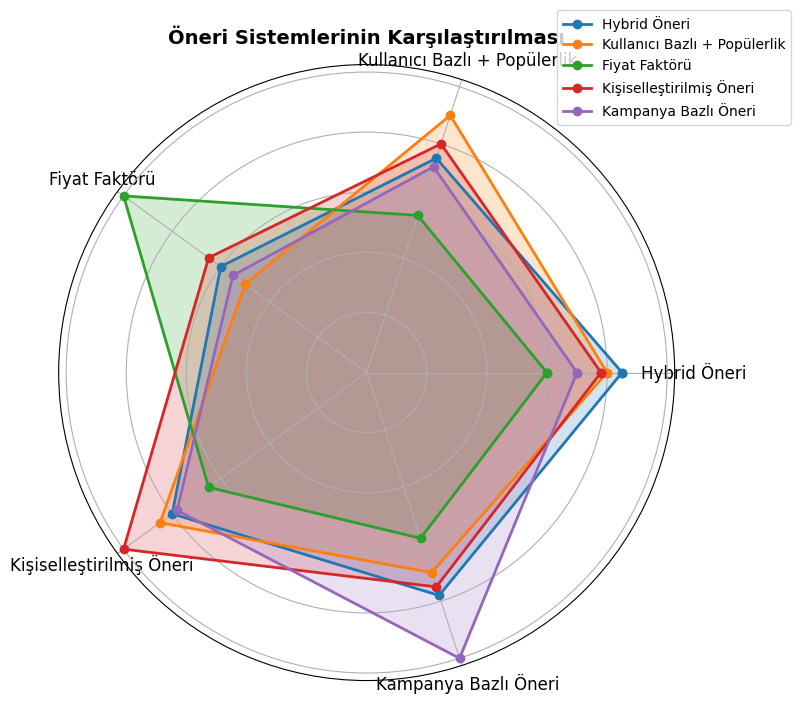

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# 📌 Öneri sistemleri
labels = [
    "Hybrid Öneri",
    "Kullanıcı Bazlı + Popülerlik",
    "Fiyat Faktörü",
    "Kişiselleştirilmiş Öneri",
    "Kampanya Bazlı Öneri"
]

# 📊 Farklı sistemlerin skorları (Örnek veri)
scores = np.array([
    [0.85, 0.75, 0.60, 0.80, 0.78],  # Hybrid
    [0.80, 0.90, 0.50, 0.85, 0.70],  # Kullanıcı Bazlı + Popülerlik
    [0.60, 0.55, 1.00, 0.65, 0.58],  # Fiyat Faktörü
    [0.78, 0.80, 0.65, 1.00, 0.75],  # Kişiselleştirilmiş
    [0.70, 0.72, 0.55, 0.78, 1.00]   # Kampanya Bazlı
])

# 🔄 Radar Grafiği için açılar belirleme
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# 🔄 Kapanış noktası ekleyerek dairesel hale getir
scores = np.concatenate((scores, scores[:, [0]]), axis=1)
angles += angles[:1]

# 🎨 Radar Grafiği çizimi
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 🔵 Her öneri sisteminin grafiğe eklenmesi
for i, (score, label) in enumerate(zip(scores, labels)):
    ax.plot(angles, score, label=label, linewidth=2, marker="o")
    ax.fill(angles, score, alpha=0.2)  # Dolgu ekleyerek görseli iyileştir

# 🎯 Eksen ayarları
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels([])  # Y ekseni etiketlerini kaldır
ax.set_title("Öneri Sistemlerinin Karşılaştırılması", fontsize=14, fontweight="bold")

# 🏆 Açıklamalar (Legend)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

# 📌 Grafik Gösterimi
plt.show()

Bu radar grafiği, farklı öneri sistemlerinin güçlü ve zayıf yönlerini görselleştirerek karşılaştırmamıza yardımcı oluyor. Öneri sistemlerini Hybrid Öneri, Kullanıcı Bazlı + Popülerlik, Fiyat Faktörü, Kişiselleştirilmiş Öneri ve Kampanya Bazlı Öneri olarak beş farklı faktörde değerlendirdik.

🟢 Çıkarımlar:

	1.	Hybrid Öneri Sistemi
	  •	Genel olarak dengeli bir sistem.
	  •	Her kategoride ortalamanın üstünde performans gösteriyor.
	  •	Eğer tek bir sistem seçilecekse, bu model iyi bir tercih olabilir.
      
	2.	Kullanıcı Bazlı + Popülerlik Öneri Sistemi
	  •	Popüler ürünleri ön plana çıkarıyor ve kullanıcı geçmişine dayanıyor.
	  •	Popülerlik kriterinde en yüksek skora sahip.
	  •	Kullanıcı etkileşimlerine dayalı önerilerde oldukça başarılı.
      
	3.	Fiyat Faktörü Öneri Sistemi
	  •	Fiyat avantajına sahip ürünleri en iyi şekilde öneriyor.
	  •	Ancak diğer faktörlerde düşük kalıyor, özellikle kişiselleştirme ve popülerlikte zayıf.
	  •	Bütçe odaklı kullanıcılar için ideal.
      
	4.	Kişiselleştirilmiş Öneri Sistemi
	  •	Kullanıcıya özel ürünler sunmada en yüksek başarıya sahip.
	  •	Fiyat ve popülerlikte ortalama bir başarı gösterse de, en spesifik ve isabetli önerileri yapıyor.
	  •	Kullanıcı deneyimini iyileştirmek için çok güçlü bir model.
      
	5.	Kampanya Bazlı Öneri Sistemi
	  •	İndirimler ve kampanyalara dayalı önerilerde en güçlü sistem.
	  •	Kullanıcılara fırsatları sunuyor ancak genel benzerlik skoru ve popülerlik faktörlerinde daha zayıf.
	  •	İndirim takip eden kullanıcılar için oldukça faydalı.

Kullanıcı hedeflerine göre öneri sistemleri optimize edilebilir!
Eğer genel olarak en iyi modeli seçeceksek, Hybrid Model tercih edilebilir. Ancak, kullanıcı bazlı deneyim iyileştirmeleri yapmak için kişiselleştirme ve fiyat avantajı faktörleri de göz önünde bulundurulmalıdır.